In [518]:
import pandas as pd
import numpy as np 
import itertools
import keras
import os
import zipfile
import requests
import tensorflow as ts
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense,BatchNormalization,Conv2D,MaxPool2D,Dropout,Input
from keras import applications 
from keras.utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import warnings
import datetime
import time

In [519]:
img_width, img_height = 128,128
# load up my datasets::
train_data_dir = r'C:\Users\bmvk1\Downloads\COVID_detection-Transfer-Learning-master\COVID_detection-Transfer-Learning-master\xray_dataset_covid19\train' 
# validating my data::
test_data_dir = r'C:\Users\bmvk1\Downloads\COVID_detection-Transfer-Learning-master\COVID_detection-Transfer-Learning-master\xray_dataset_covid19\test'

In [520]:
# the number of itereations for training the top modell::
epochs = 8 #this has been modified following several custom model runs::
# batch size that predict_data_gen and flow_from_directory use 
batch_size = 64

In [521]:
def main_genu_generato(path):
    generation = datagen.flow_from_directory( 
        path, 
        target_size=(img_width, img_height), 
        batch_size=batch_size, 
        class_mode="categorical", 
        shuffle=False) 

    bm_samples = len(generation.filenames) 
    num_classes = len(generation.class_indices) 

    predict_size_train = int(math.ceil(bm_samples / batch_size)) 
    # getting the class labelling for the training data_in an original order-- 
    labelling = generation.classes 

    # converting the train labeling in to categorical_Vectorss ::
    labelling = to_categorical(labelling, num_classes=num_classes)
    
    return (generation,bm_samples,predict_size_train,labelling)

In [522]:
datagen = ImageDataGenerator(rescale=1. / 255) 

In [523]:
generation_train,nb_train_samples,predict_size_train,train_labelling = main_genu_generato(train_data_dir)
generation_test,nb_test_samples,predict_size_test,test_labelling    = main_genu_generato(test_data_dir)
num_classes = 3
class_labelling=list(generation_train.class_indices.keys())

Found 222 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [524]:
def applying_pre_train(pretrained_model,generation,predict_size):
    return pretrained_model.predict(generation, predict_size)

In [525]:
def cnn_after_pretrainedModel(input_shape):
    # Define the Sequential model
    custom_modell = Sequential()
    # Add Input layer to define the input shape
    custom_modell.add(Input(shape=input_shape))
    # Add Flatten layer (input shape is already defined)
    custom_modell.add(Flatten())
    # Add Dense layers with LeakyReLU activations and Dropout
    custom_modell.add(Dense(128, activation=keras.layers.LeakyReLU(negative_slope=0.3)))
    custom_modell.add(Dropout(0.5))
    custom_modell.add(Dense(64, activation=keras.layers.LeakyReLU(negative_slope=0.3)))
    custom_modell.add(Dropout(0.3))
    # Add output layer with softmax activation
    custom_modell.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    custom_modell.compile(loss='categorical_crossentropy',
                          optimizer=optimizers.Adam(learning_rate=1e-4),
                          metrics=['acc'])
    return custom_modell

In [526]:
def Trans_fer_Learn(pretrained_model,epochs=25):
    #Appling Pretrained Model to train and test datasets
    train_data = applying_pre_train(pretrained_model,generation_train,predict_size_train)
    test_data  = applying_pre_train(pretrained_model,generation_test,predict_size_test)
    custom_modell      = cnn_after_pretrainedModel(train_data.shape[1:])
    history = custom_modell.fit(train_data, train_labelling, 
       epochs=epochs,
       batch_size=batch_size, 
       validation_data=(test_data, test_labelling))
    (eval_loss, eval_accuracy) = custom_modell.evaluate(test_data, test_labelling, batch_size=batch_size,verbose=1)
    print("--[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
    print("--[INFO] Loss: {}".format(eval_loss))
    
    return train_data,test_data,custom_modell,history,eval_accuracy

In [527]:
def plot_graphs(history):
    #Graphing our training and validation
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Train_ACC')
    plt.plot(epochs, val_acc, 'b', label='Valid_ACC')
    plt.title('--Training_and_validation_ACCURACY--')
    plt.ylabel('accuracy') 
    plt.xlabel('epochs')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='TRAIN_LOSS')
    plt.plot(epochs, val_loss, 'b', label='VALID_LOSS')
    plt.title('--Training_and_Validation_LOSS--')
    plt.ylabel('LOSS') 
    plt.xlabel('EPOCHES')
    plt.legend()
    plt.show()

In [528]:
#loadind_pre_trained_model_VGG:
model_name="VGG"
PRETRAIN_VGG  = applications.VGG16(include_top=False, weights='imagenet')
train_data,test_data,model_vgg,history_vgg,acc_vgg = Trans_fer_Learn(PRETRAIN_VGG)
print()


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - acc: 0.3390 - loss: 1.3791 - val_acc: 0.4833 - val_loss: 1.0361
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.4015 - loss: 1.1658 - val_acc: 0.7000 - val_loss: 0.8398
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.4986 - loss: 0.9901 - val_acc: 0.8000 - val_loss: 0.7374
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.6106 - loss: 0.8382 - val_acc: 0.8667 - val_loss: 0.6553
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.6821 - loss: 0.7251 - val_acc: 0.8833 - val_loss: 0.5954
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.7604 - loss: 0.6347 - val_acc: 0.9500 - val_loss: 0.5160
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.8002 - loss: 0.5835 - val_acc: 0.9167 - val_loss: 0.4344
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8459 - loss: 0.5144 - val_acc: 0.8833 - val_loss: 0.3890
Epoch 9

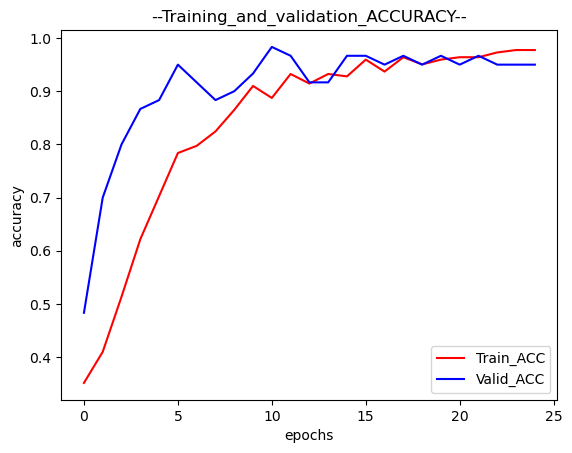

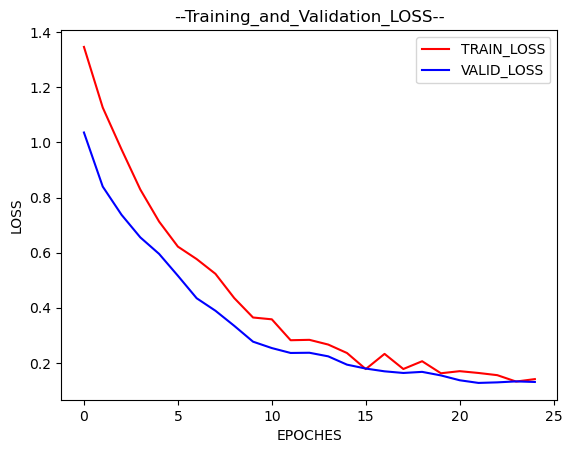

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [529]:
plot_graphs(history_vgg)
preds=np.round(model_vgg.predict(test_data),0)

In [530]:
classified_matric_VGG=metrics.classification_report(test_labelling,preds,target_names=class_labelling, zero_division=0)
print(classified_matric_VGG)

              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00        20
      NORMAL       1.00      0.85      0.92        20
   PNEUMONIA       0.86      0.95      0.90        20

   micro avg       0.95      0.93      0.94        60
   macro avg       0.95      0.93      0.94        60
weighted avg       0.95      0.93      0.94        60
 samples avg       0.93      0.93      0.93        60



In [531]:
#Loading the Pre_train_Model
model_name="INCEPTION NET"
Pretrain_Model_g_net  = applications.InceptionV3(include_top=False, weights='imagenet')
train_data,test_data,model_googleNet,history_googleNet,acc_googleNet = Trans_fer_Learn(Pretrain_Model_g_net)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - acc: 0.3145 - loss: 3.2121 - val_acc: 0.8500 - val_loss: 0.5124
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.6371 - loss: 1.2279 - val_acc: 0.8333 - val_loss: 0.4278
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.7523 - loss: 0.8490 - val_acc: 0.8833 - val_loss: 0.3286
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7890 - loss: 0.7122 - val_acc: 0.9000 - val_loss: 0.3202
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8051 - loss: 0.6209 - val_acc: 0.8500 - val_loss: 0.3916
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7998 - loss: 0.6693 - val_acc: 0.8000 - val_loss: 0.5086
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8541 - loss: 0.3301 - val_acc: 0.7667 - val_loss: 0.5571
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.8559 - loss: 0.4118 - val_acc: 0.8167 - val_loss: 0.4745
Epoch 

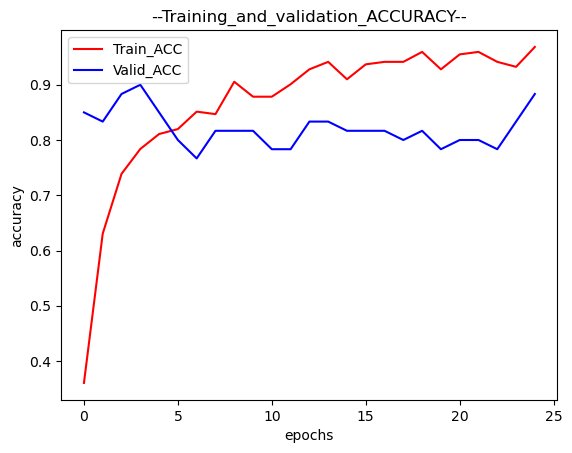

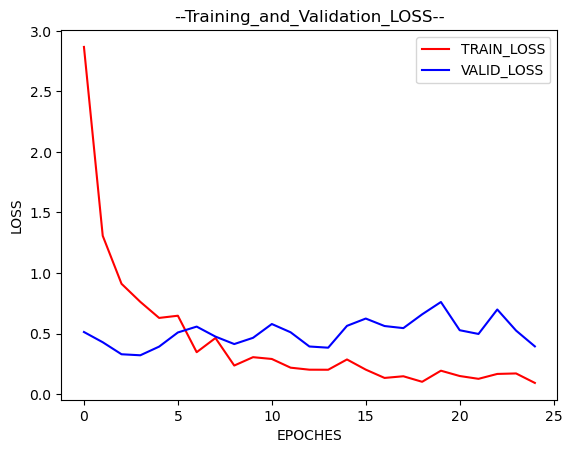

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [532]:
plot_graphs(history_googleNet)
preds=np.round(model_googleNet.predict(test_data),0)

In [533]:
classify_matrics_googleNet=metrics.classification_report(test_labelling,preds,target_names=class_labelling,zero_division=0)
print(classify_matrics_googleNet)

              precision    recall  f1-score   support

       COVID       1.00      0.85      0.92        20
      NORMAL       0.78      0.90      0.84        20
   PNEUMONIA       0.90      0.90      0.90        20

   micro avg       0.88      0.88      0.88        60
   macro avg       0.89      0.88      0.89        60
weighted avg       0.89      0.88      0.89        60
 samples avg       0.88      0.88      0.88        60



In [534]:
#Loading the Pre_Trained_Model
model_name="INCEPTION NET"
PRETRAIN_RESNET  = applications.ResNet50(include_top=False, weights='imagenet')
train_data,test_data,model_resNet,history_resNet,acc_resNet= Trans_fer_Learn(PRETRAIN_RESNET)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - acc: 0.2831 - loss: 1.4999 - val_acc: 0.3333 - val_loss: 1.1368
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.3744 - loss: 1.2469 - val_acc: 0.3333 - val_loss: 1.1386
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.4093 - loss: 1.1563 - val_acc: 0.3667 - val_loss: 1.0681
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - acc: 0.4234 - loss: 1.0922 - val_acc: 0.3167 - val_loss: 1.0632
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.4114 - loss: 1.0913 - val_acc: 0.4167 - val_loss: 1.0625
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.3558 - loss: 1.1345 - val_acc: 0.5167 - val_loss: 1.0536
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.4162 - loss: 1.0735 - val_acc: 0.5667 - val_loss: 1.0402
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.4174 - loss: 1.0716 - val_acc: 0.5167 - val_loss: 1.0300
Epoch 9

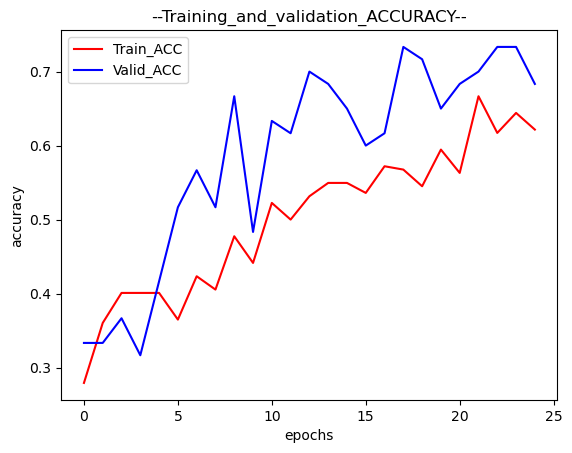

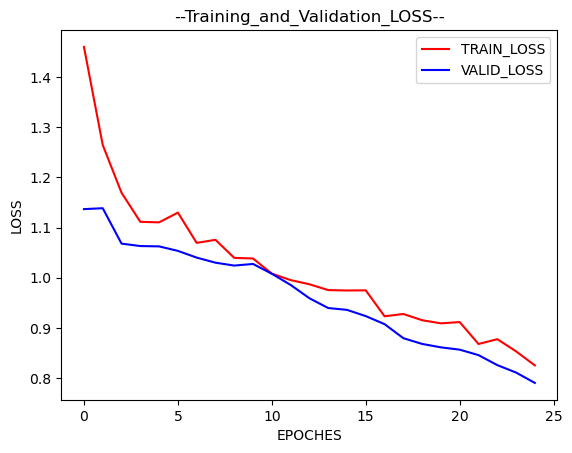

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [535]:
plot_graphs(history_resNet)
preds=np.round(model_resNet.predict(test_data),0)

In [536]:
Clasifing_matric_RESNET=metrics.classification_report(test_labelling,preds,target_names=class_labelling, zero_division=0)
print(Clasifing_matric_RESNET)

              precision    recall  f1-score   support

       COVID       0.95      1.00      0.98        20
      NORMAL       0.60      0.60      0.60        20
   PNEUMONIA       0.00      0.00      0.00        20

   micro avg       0.78      0.53      0.63        60
   macro avg       0.52      0.53      0.53        60
weighted avg       0.52      0.53      0.53        60
 samples avg       0.53      0.53      0.53        60



In [537]:
print("``//\\The Accuracy of the Models\\//``")
print("--VGG--\t\t\t",acc_vgg)
print("--Google_Net--\t\t",acc_googleNet)
print("--ResNet--\t\t",acc_resNet)

``//\The Accuracy of the Models\//``
--VGG--			 0.949999988079071
--Google_Net--		 0.8833333253860474
--ResNet--		 0.6833333373069763


In [538]:
def PRETRAIN_VGG(file_path):
   print("[INFO] Loading and Preprocessing the PRETRAIN_VGG…!!!!!") 
   PRETRAIN_VGG = load_img(file_path, target_size=(img_width, img_height))
   PRETRAIN_VGG = img_to_array(PRETRAIN_VGG) 
   PRETRAIN_VGG = np.expand_dims(PRETRAIN_VGG, axis=0)
   PRETRAIN_VGG /= 255. 
   return PRETRAIN_VGG

[INFO] loading and preprocessing image…
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
ID: 0, Label: COVID 0.01%
ID: 1, Label: NORMAL 99.71%
ID: 2, Label: PNEUMONIA 0.28%
Final Decision:
.
..
...
ID: 1, Label: NORMAL


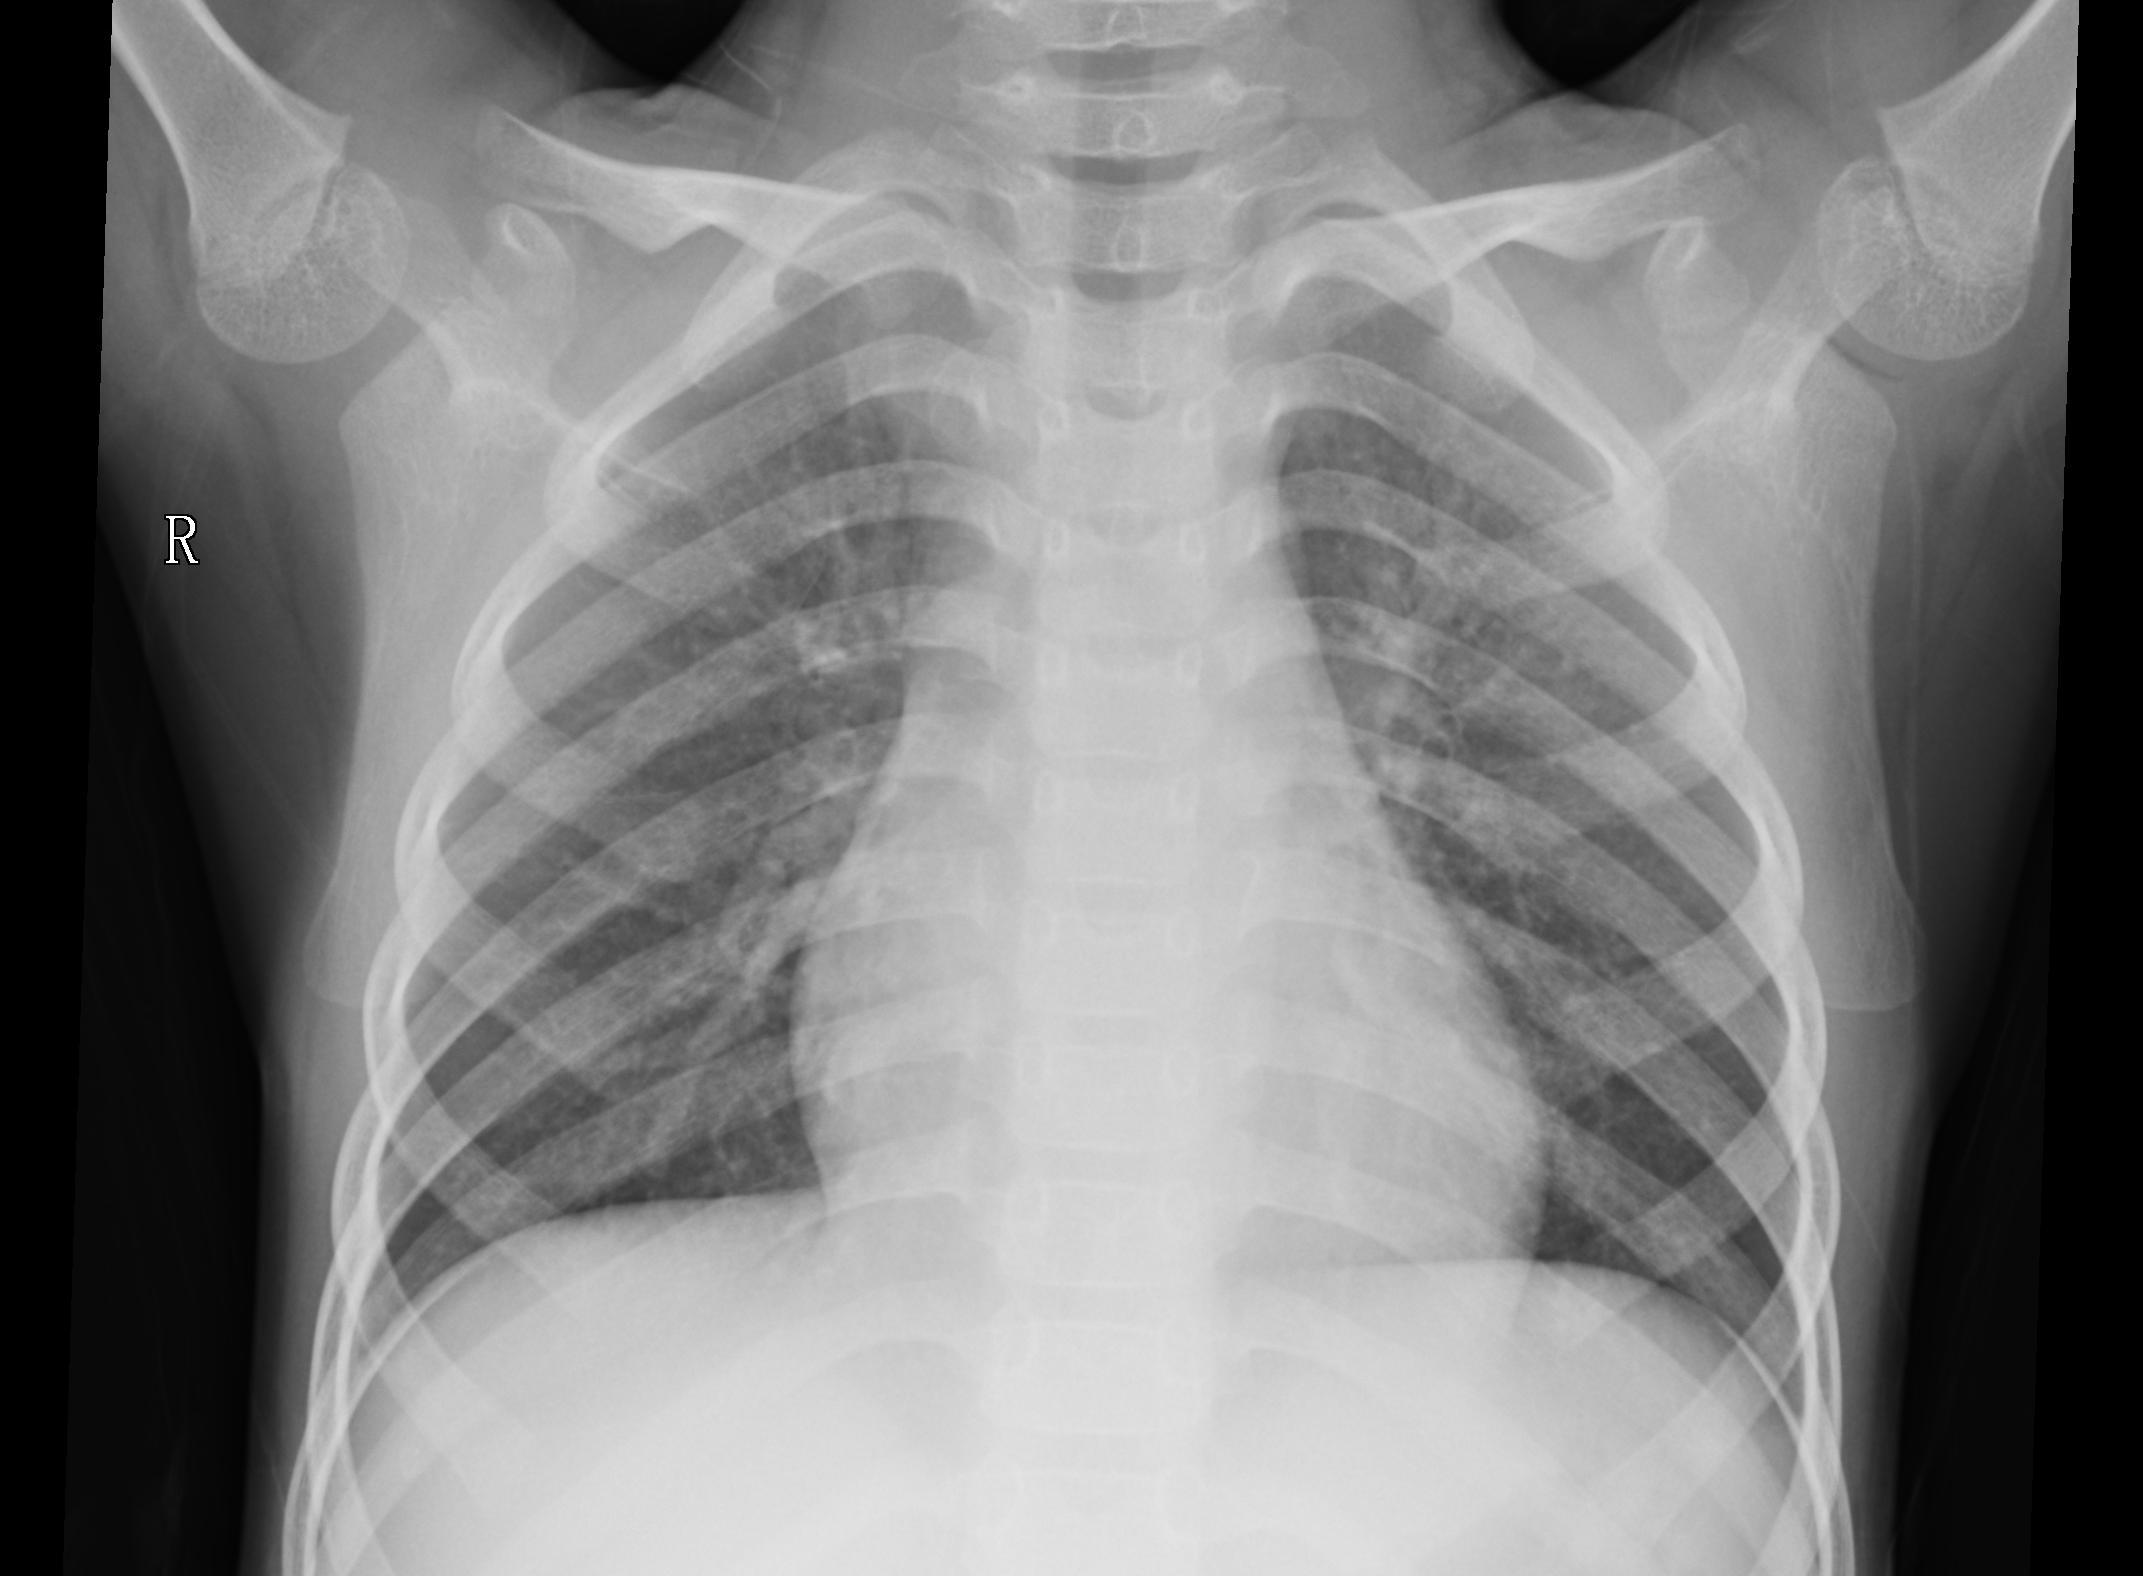

In [566]:
def test_single_image(pretrained_model, custom_modell, path):
    # Preprocess the image using a custom function (assuming read_image is defined)
    images = read_image(path)  # Use your image preprocessing function here
    
    time.sleep(0.5)
    
    # Get feature extraction from the pre-trained model (ResNet, VGG, etc.)
    bt_prediction = pretrained_model.predict(images) 
    
    # Get the final prediction from your custom model
    preds = custom_modell.predict(bt_prediction)
    
    # Print the probabilities for each class
    for idx, animal, x in zip(range(0, 3), class_labelling, preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100, 2)))
    
    print('Final Decision:')
    time.sleep(0.5)
    
    # Simulate some suspense before printing the final decision
    for x in range(3):
        print('.' * (x + 1))
        time.sleep(0.2)
    
    # Get the predicted class index (this should be an integer)
    class_predicted = np.argmax(preds, axis=1)[0]  # Extract the first element to make it an integer
    
    # Map the predicted class index to the class label using class indices
    class_dictionary = generation_test.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    
    # Print the final predicted class
    print("ID: {}, Label: {}".format(class_predicted, inv_map[class_predicted])) 
    
    # Return the original image (optional)
    return load_img(path)

# Define the path to the image
path = r'D:\NORMAL2-IM-0092-0001.jpeg'

# Call the function to test a single image
test_single_image(Pretrain_Model_g_net, model_googleNet, path)

